# Clinical BERT Model Code

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Installed Libraries

In [ ]:
!pip install matplotlib
!pip install imbalanced-learn
!pip install --upgrade ipywidgets
!pip install optuna
!pip install transformers --upgrade
!pip install accelerate --upgrade
!pip install gensim
!pip install nltk
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 59.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 64.0 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.5
    Uninstalling widgetsnbextension-3.6.5:
      Successfully uninstalled widgetsnbextension-3.6.5
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 54.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 29.8 MB/s et

Importing all Libraries needed for implemetation

In [ ]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import re
import string
import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from tqdm import tqdm
import transformers
import torch
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve, auc
from sklearn.svm import SVC
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from transformers import BertForSequenceClassification, BertTokenizer, Trainer, TrainingArguments
from datasets import Dataset
import nltk
nltk.download('punkt')





[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Load CSV files:
1. train_bert_final.csv
2. test_bert_final.csv
3. validation_bert_final.csv

In [ ]:
#Reading the train data from drive
df_train = pd.read_csv('/content/drive/MyDrive/Dataset for Models/train_bert_final.csv')
#Reading the train data from drive
df_validation = pd.read_csv('/content/drive/MyDrive/Dataset for Models/test_bert_final.csv')
#Reading the train data from drive
df_test = pd.read_csv('/content/drive/MyDrive/Dataset for Models/validation_bert_final.csv')

Implementation of Clinical BERT model

In [ ]:
# Load Clinical BERT model and tokenizer
model = BertForSequenceClassification.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')
tokenizer = BertTokenizer.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Convert the datasets to HuggingFace Dataset format
train_dataset = Dataset.from_pandas(df_train_bert)
test_dataset = Dataset.from_pandas(df_test_bert)
val_dataset = Dataset.from_pandas(df_validation_bert)


In [ ]:
def tokenize_function(examples):
    if not all(isinstance(item, str) for item in examples['text']):
        problematic_items = [item for item in examples['text'] if not isinstance(item, str)]
        print(f"Non-string items: {problematic_items}")
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=512)


In [ ]:
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)


Map:   0%|          | 0/4685 [00:00<?, ? examples/s]

Map:   0%|          | 0/1005 [00:00<?, ? examples/s]

Map:   0%|          | 0/1004 [00:00<?, ? examples/s]

In [ ]:
# Set the format to torch tensors
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
val_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

In [ ]:
training_args = TrainingArguments(
    per_device_train_batch_size=8,      # Reduce batch size for memory efficiency
    per_device_eval_batch_size=8,       # Keep it similar to per_device_train_batch_size
    num_train_epochs=4,                 # Train for 3 epochs
    evaluation_strategy="steps",
    save_steps=1000,                    # Save checkpoints less frequently
    eval_steps=1500,                    # Evaluate less frequently
    logging_steps=500,                  # Log less frequently
    learning_rate=3e-5,                 # Slightly higher learning rate for faster convergence
    warmup_steps=300,                   # Gradually warm up the learning rate
    weight_decay=0.01,                  # Apply L2 regularization
    output_dir='./results',
    logging_dir='./logs',
    logging_first_step=False,           # No need to log the very first step
    gradient_accumulation_steps=4,      # Further reduce memory usage with gradient accumulation
)


In [ ]:
# Compute metrics function for evaluation

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    acc = accuracy_score(labels, predictions)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:
# Create trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)


In [ ]:
# Train the model with built-in progress monitoring and logging
trainer.train()

  0%|          | 0/584 [00:00<?, ?it/s]

{'loss': 0.6192, 'learning_rate': 8.873239436619718e-06, 'epoch': 3.41}
{'train_runtime': 151781.4276, 'train_samples_per_second': 0.123, 'train_steps_per_second': 0.004, 'train_loss': 0.6070445726995599, 'epoch': 3.99}


TrainOutput(global_step=584, training_loss=0.6070445726995599, metrics={'train_runtime': 151781.4276, 'train_samples_per_second': 0.123, 'train_steps_per_second': 0.004, 'train_loss': 0.6070445726995599, 'epoch': 3.99})

In [ ]:
# Evaluate the model on validation set
eval_results = trainer.evaluate(eval_dataset=val_dataset)
print("Validation Results:", eval_results)


  0%|          | 0/126 [00:00<?, ?it/s]

Validation Results: {'eval_loss': 0.6272291541099548, 'eval_accuracy': 0.649402390438247, 'eval_f1': 0.6173913043478261, 'eval_precision': 0.610752688172043, 'eval_recall': 0.6241758241758242, 'eval_runtime': 2861.8526, 'eval_samples_per_second': 0.351, 'eval_steps_per_second': 0.044, 'epoch': 3.99}


In [ ]:
# Evaluate the model on test dataset
test_results = trainer.evaluate(test_dataset)
print("Test Results:", test_results)

  0%|          | 0/126 [00:00<?, ?it/s]

Test Results: {'eval_loss': 0.6027553677558899, 'eval_accuracy': 0.6716417910447762, 'eval_f1': 0.6659919028340081, 'eval_precision': 0.6854166666666667, 'eval_recall': 0.6476377952755905, 'eval_runtime': 2867.7463, 'eval_samples_per_second': 0.35, 'eval_steps_per_second': 0.044, 'epoch': 3.99}


In [ ]:
# Extract and display the accuracy
accuracy = test_results['eval_accuracy']
print(f"Accuracy on test dataset: {accuracy:.2f}")

recall = test_results['eval_recall']
print(f"Recall on test dataset: {recall:.2f}")

precision = test_results['eval_precision']
print(f"Precision on test dataset: {precision:.2f}")


Accuracy on test dataset: 0.67
Recall on test dataset: 0.65
Precision on test dataset: 0.69


In [ ]:
# Evaluate the model on test dataset
test_results

{'eval_loss': 0.6027553677558899,
 'eval_accuracy': 0.6716417910447762,
 'eval_f1': 0.6659919028340081,
 'eval_precision': 0.6854166666666667,
 'eval_recall': 0.6476377952755905,
 'eval_runtime': 2867.7463,
 'eval_samples_per_second': 0.35,
 'eval_steps_per_second': 0.044,
 'epoch': 3.99}

In [ ]:
# Predict the model's output on the test dataset
predictions = trainer.predict(test_dataset)

  0%|          | 0/126 [00:00<?, ?it/s]

In [ ]:
# Get the predicted logits and true labels
predicted_logits = predictions.predictions
true_labels = test_dataset['label']
predicted_labels = np.argmax(predicted_logits, axis=-1)


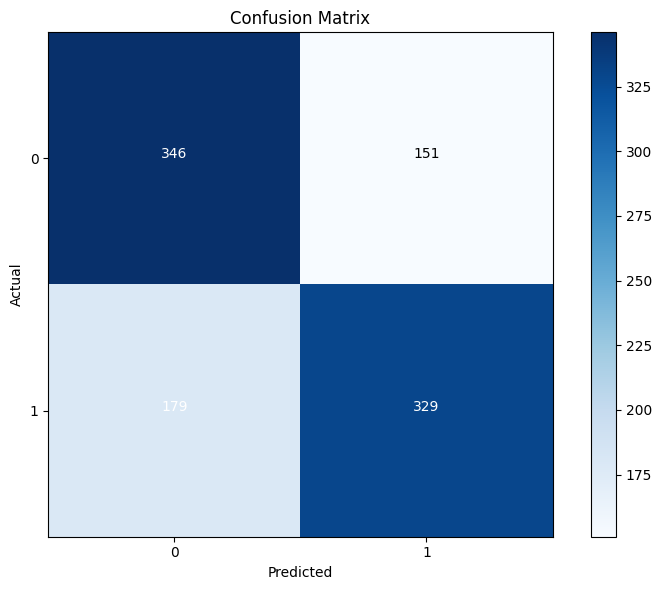

In [ ]:
# Calculate the confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels)

# Create Confusion Matrix Plot
plt.figure(figsize=(8, 6))
plt.imshow(confusion, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()

# Add Labels and Annotations
classes = [0, 1]  # Assuming your classes are represented as 0 and 1
tick_marks = np.arange(len(classes))

plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

plt.xlabel('Predicted')
plt.ylabel('Actual')

# Annotate cells with counts
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, str(confusion[i, j]),
                 horizontalalignment="center",
                 color="white" if confusion[i, j] > confusion.max() / 2 else "black")

plt.tight_layout()
plt.show()

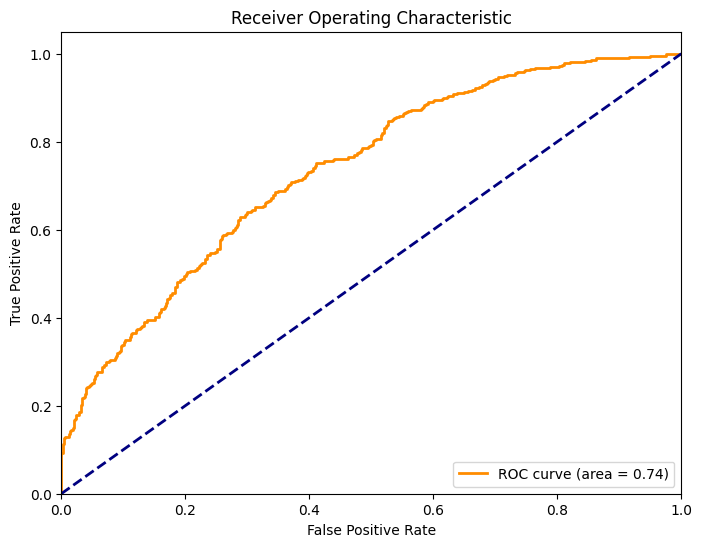

In [ ]:
from sklearn.metrics import roc_curve, auc

predicted_probabilities = predicted_logits[:, 1]  # Assuming you want probabilities for positive class

# Calculate ROC curve
fpr, tpr, _ = roc_curve(true_labels, predicted_probabilities)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

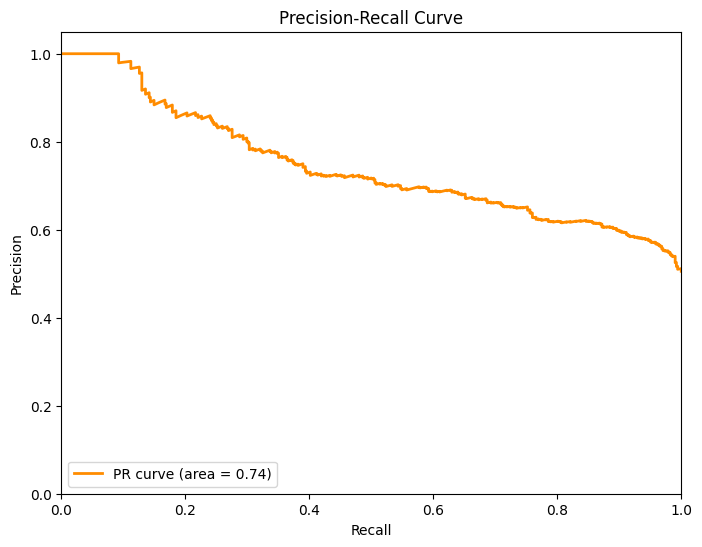

In [ ]:
from sklearn.metrics import precision_recall_curve, auc

# Calculate Precision-Recall curve
precision, recall, _ = precision_recall_curve(true_labels, predicted_probabilities)
pr_auc = auc(recall, precision)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='darkorange', lw=2, label='PR curve (area = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.show()